# RAG Post-Retrieval Optimization Techniques

## Learning Objectives
In this tutorial, you'll learn to:
- Implement re-ranking mechanisms for better retrieval
- Apply context enhancement and compression techniques
- Use advanced prompting strategies for RAG
- Build hierarchical retrieval systems

## What is Post-Retrieval Optimization?

Post-retrieval optimization techniques aim to enhance the quality of generated responses, meaning that their work begins after the retrieval process has been completed. This diverse group of techniques includes using models to re-rank retrieved results, enhancing or compressing the retrieved context, prompt engineering, and fine-tuning the generative LLM on external data.

Post-retrieval optimization enhances RAG systems **after** documents are retrieved but **before** generation. These techniques improve response quality by:
- Re-ranking results for better relevance
- Enhancing context with additional information
- Compressing content to reduce noise
- Using advanced prompting strategies

Unlike pre-retrieval optimization that focuses on improving queries and indexing, post-retrieval optimization works with the documents that have already been retrieved to maximize their utility for generation.

## Environment Setup

We need to install several specialized packages for different post-retrieval optimization techniques. Each package serves a specific purpose in our RAG pipeline enhancement.

In [ ]:
# Install required packages for RAG post-retrieval optimization
# langchain: Core framework for building LLM applications
# langchain-openai: OpenAI integrations (embeddings and chat models)
# langchain-chroma: Vector database integration
# langchain-cohere: Cohere's re-ranking model integration
# chromadb: Vector database for storing embeddings
# cohere: Cohere API client for re-ranking
# flashrank: Fast and efficient re-ranking model
# sentence-transformers: Pre-trained sentence embedding models
# tiktoken: Tokenizer for counting tokens (cost estimation)
%pip install langchain langchain-openai langchain-chroma langchain-cohere chromadb cohere flashrank sentence-transformers tiktoken flashrank

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# Set up API keys for the services we'll use
# OpenAI: For embeddings and language model generation
os.environ["OPENAI_API_KEY"] = "<your-openai-api-key>"

# Cohere: For re-ranking retrieved documents
# Get your Cohere API key from https://dashboard.cohere.com/api-keys
os.environ["COHERE_API_KEY"] = "<your-cohere-api-key>"

print("✅ Environment setup complete!")

In [ ]:
# Import all necessary libraries for our RAG post-retrieval optimization
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # OpenAI models
from langchain_chroma import Chroma  # Vector database
from langchain.retrievers import ContextualCompressionRetriever  # Compression wrapper
from langchain_community.document_compressors import FlashrankRerank  # FlashRank re-ranker
from langchain_cohere import CohereRerank  # Cohere re-ranker
from langchain.schema import Document  # Document object structure
from langchain.prompts import ChatPromptTemplate  # Prompt templates
from langchain.schema.runnable import RunnablePassthrough  # Chain utilities
from langchain.schema import StrOutputParser  # Output parsing

import logging
import warnings

# Reduce noise in console output by setting log levels
# This helps focus on our results rather than HTTP request details
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# Disable all warnings for cleaner output
warnings.filterwarnings('ignore')

print("📦 All packages imported successfully!")

## Sample Data Setup

We'll create a comprehensive set of sample documents about AI and machine learning topics. These documents will serve as our knowledge base for demonstrating various post-retrieval optimization techniques. The documents cover different aspects of AI to provide diverse content for testing retrieval and re-ranking.

In [ ]:
# Create sample documents covering various AI/ML topics
# These documents will be used to demonstrate post-retrieval optimization techniques
# Each document covers a specific AI concept with sufficient detail for meaningful retrieval
sample_docs = [
    "Machine learning is a subset of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed. It involves algorithms that can identify patterns in data.",
    "Deep learning is a subset of machine learning that uses neural networks with multiple layers to model and understand complex patterns in data. It has revolutionized fields like computer vision and natural language processing.",
    "Natural Language Processing (NLP) is a branch of AI that helps computers understand, interpret and manipulate human language. It combines computational linguistics with statistical and machine learning models.",
    "Computer vision is an AI field that trains machines to interpret and understand visual information from the world. It involves methods for acquiring, processing, analyzing and understanding digital images.",
    "Reinforcement learning is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize cumulative reward. It's inspired by behavioral psychology.",
    "Transformers are a neural network architecture that has revolutionized NLP. They use self-attention mechanisms to process sequential data and form the backbone of models like GPT and BERT.",
    "Large Language Models (LLMs) are AI models trained on vast amounts of text data to understand and generate human-like text. Examples include GPT-4, Claude, and PaLM.",
    "Retrieval Augmented Generation (RAG) combines the parametric knowledge of language models with non-parametric retrieval from external knowledge bases to improve factual accuracy.",
    "Vector databases store high-dimensional vectors representing data embeddings, enabling fast similarity search for applications like recommendation systems and semantic search.",
    "Fine-tuning involves adapting a pre-trained model to a specific task or domain by training it on task-specific data, allowing for better performance on specialized applications."
]

# Convert text strings to Document objects with metadata
# Document objects contain both content and metadata for better organization
documents = [Document(page_content=doc, metadata={"id": i, "topic": "AI"}) for i, doc in enumerate(sample_docs)]

print(f"📚 Created {len(documents)} sample documents")

In [ ]:
import time

# Initialize OpenAI embeddings model
# text-embedding-3-small: Cost-effective model with good performance
# dimensions=1536: Standard dimension size for this model
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",  # Cost-effective and efficient
    dimensions=1536
)

# Create unique collection name using timestamp to avoid conflicts
# This ensures we start with a fresh vector database
collection_name = f"docs_{int(time.time())}"

# Create vector store from our documents
# Chroma: Local vector database that persists to disk
# from_documents: Creates embeddings and stores them automatically
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory="./chroma_db",  # Local storage directory
    collection_name=collection_name
)

# Create base retriever that will be enhanced with post-retrieval techniques
# k=8: Retrieve more documents than needed for re-ranking
# Over-retrieval is important for re-ranking to have candidates to choose from
base_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 8}  # Retrieve more for re-ranking
)

print("🗄️ Vector store created and base retriever initialized")

# 1. Re-Ranking Techniques

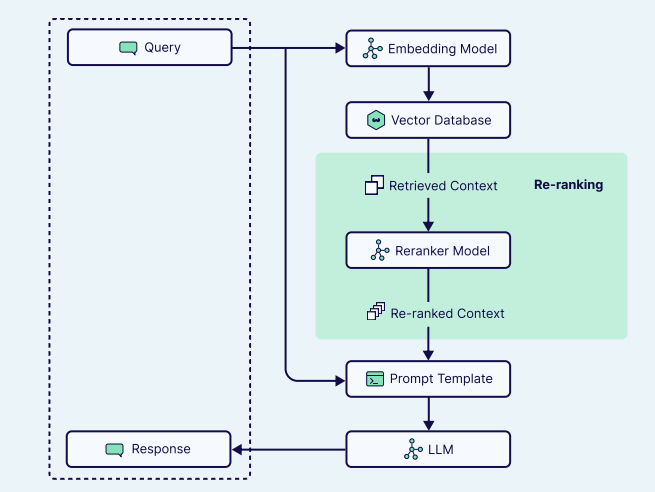

## What is Re-ranking?

One proven method to improve the performance of your information retrieval system is to leverage a retrieve-and-rerank pipeline. A retrieve-and-rerank pipeline combines the speed of vector search with the contextual richness of a re-ranking model.

In vector search, the query and documents are processed separately. First, the documents are pre-indexed. Then, at query time, the query is processed, and the documents closest in vector space are retrieved. While vector search is a fast method to retrieve candidates, it can miss contextual nuances.

This is where re-ranking models come into play. Because re-ranking models process the query and the documents together at query time, they can capture more contextual nuances. However, they are usually complex and resource-intensive and thus not suitable for first-stage retrieval like vector search.

By combining vector search with re-ranking models, you can quickly cast a wide net of potential candidates and then re-order them to improve the quality of relevant context in your prompt. Note that when using a re-ranking model, you should over-retrieve chunks to filter out less relevant ones later.

### Re-ranking Process:
1. **Over-retrieving** initial candidates (e.g., top 20)
2. **Re-ranking** using cross-encoders that process query + document together
3. **Selecting** top-k most relevant documents

### Why Re-rank?
- Vector search processes query and documents **separately**
- Re-rankers process them **together** for better contextual understanding
- Combines speed of vector search with accuracy of cross-encoders

## 1.1 Cohere Re-ranking

Cohere provides state-of-the-art re-ranking models that excel at understanding the relationship between queries and documents. The rerank-v3.5 model is multilingual and provides highly accurate relevance scoring.

In [ ]:
# Initialize Cohere re-ranking model
# rerank-v3.5: Latest multilingual re-ranking model from Cohere
# top_n=5: Return only the top 5 most relevant documents after re-ranking
cohere_reranker = CohereRerank(
    model="rerank-v3.5",  # Latest multilingual model
    top_n=5  # Return top 5 after reranking
)

# Create compression retriever that wraps our base retriever
# ContextualCompressionRetriever: Applies post-processing to retrieved documents
# base_compressor: The re-ranking model that will reorder results
# base_retriever: Our original vector search retriever
cohere_retriever = ContextualCompressionRetriever(
    base_compressor=cohere_reranker,
    base_retriever=base_retriever
)

print("🔄 Cohere re-ranker initialized")

In [ ]:
# Compare base retrieval vs Cohere re-ranking
# This demonstrates how re-ranking can improve result relevance
query = "What are neural networks with multiple layers?"

# Get results from base retriever (vector search only)
# This shows what we get with traditional semantic search
base_results = base_retriever.invoke(query)
print("📥 Base Retriever Results:")
for i, doc in enumerate(base_results[:3]):
    print(f"{i+1}. {doc.page_content[:100]}...")

print("\n" + "="*50 + "\n")

# Get results with Cohere re-ranking applied
# The re-ranker analyzes query-document pairs for better relevance
reranked_results = cohere_retriever.invoke(query)
print("🎯 Cohere Re-ranked Results:")
for i, doc in enumerate(reranked_results[:3]):
    print(f"{i+1}. {doc.page_content[:100]}...")

## 1.2 Cross-Encoder Re-ranking with FlashRank

FlashRank provides fast, efficient cross-encoder models for re-ranking. Cross-encoders process query-document pairs together, providing more accurate relevance scores than bi-encoders used in vector search.

In [ ]:
from flashrank import Ranker

# Initialize FlashRank client with a specific cross-encoder model
# ms-marco-MiniLM-L-12-v2: Efficient cross-encoder trained on MS MARCO dataset
# This model is optimized for passage ranking tasks
flashrank_client = Ranker(model_name="ms-marco-MiniLM-L-12-v2")

# Create FlashRank re-ranker wrapper for LangChain integration
# FlashrankRerank: LangChain wrapper for FlashRank models
# client: The FlashRank model instance
# top_n=5: Return top 5 documents after re-ranking
flashrank_reranker = FlashrankRerank(
    client=flashrank_client,
    top_n=5
)


# Create compression retriever using FlashRank
# This combines vector search with cross-encoder re-ranking
flashrank_retriever = ContextualCompressionRetriever(
    base_compressor=flashrank_reranker,
    base_retriever=base_retriever
)

print("⚡ FlashRank re-ranker initialized")

In [ ]:
# Compare different re-ranking approaches
# This shows how different re-ranking models can produce different results
query = "How do machines learn from data patterns?"

print("🔍 Query:", query)
print("\n" + "="*60 + "\n")

# Get results using FlashRank re-ranking
# FlashRank uses local cross-encoder models for fast processing
flashrank_results = flashrank_retriever.invoke(query)
print("⚡ FlashRank Re-ranked:")
for i, doc in enumerate(flashrank_results):
    print(f"{i+1}. {doc.page_content[:150]}...")

print("\n" + "-"*30 + "\n")

# Get results using Cohere re-ranking
# Cohere uses cloud-based models with different training data
cohere_results = cohere_retriever.invoke(query)
print("🎯 Cohere Re-ranked:")
for i, doc in enumerate(cohere_results):
    print(f"{i+1}. {doc.page_content[:150]}...")

# 2. Context Enhancement with Metadata

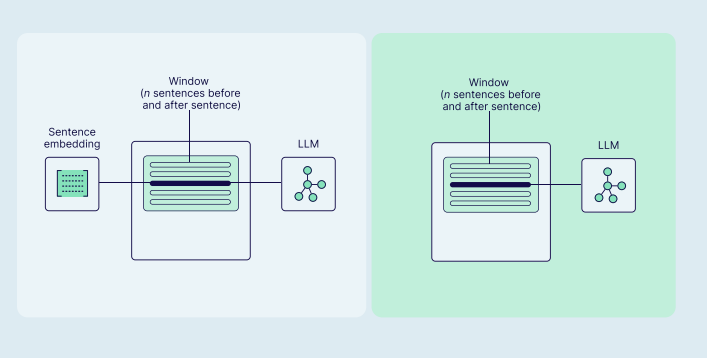

## What is Context Enhancement?

After retrieval, it can be beneficial to post-process the retrieved context for generation. For example, if the retrieved context might benefit from additional information you can enhance it with metadata. On the other hand, if it contains redundant data, you can compress it.

Context enhancement is particularly useful when data needs to be pre-processed into smaller chunk sizes to achieve better retrieval precision that doesn't contain enough contextual information to generate high-quality responses. In this case, you can apply a technique called "Sentence window retrieval". This technique chunks the initial document into smaller pieces (usually single sentences) but stores a larger context window in its metadata. At retrieval time, the smaller chunks help improve retrieval precision. After retrieval, the retrieved smaller chunks are replaced with the larger context window to improve generation quality.

Context enhancement improves retrieved content by:
- **Adding metadata** (timestamps, sources, categories)
- **Expanding context** (parent documents, surrounding text)
- **Enriching information** (related content, summaries)

### Sentence Window Retrieval Benefits:
- **Index**: Small chunks (sentences) for precision
- **Retrieve**: Larger context windows for comprehension
- **Best of both worlds**: Precise retrieval + rich context

In [ ]:
# Create enhanced documents with rich metadata for demonstration
# This shows how documents can store additional context information
# The metadata includes parent content that provides broader context
enhanced_docs = [
    Document(
        page_content="Machine learning enables computers to learn from experience without explicit programming.",
        metadata={
            "title": "Introduction to Machine Learning",
            "category": "Fundamentals",
            "difficulty": "Beginner",
            "parent_content": "Machine learning is a subset of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed. It involves algorithms that can identify patterns in data and make predictions or decisions based on that learning.",
            "related_topics": ["AI", "Algorithms", "Data Science"]
        }
    ),
    Document(
        page_content="Deep learning uses neural networks with multiple layers.",
        metadata={
            "title": "Deep Learning Basics",
            "category": "Advanced",
            "difficulty": "Intermediate",
            "parent_content": "Deep learning is a subset of machine learning that uses neural networks with multiple layers to model and understand complex patterns in data. It has revolutionized fields like computer vision and natural language processing by enabling machines to learn hierarchical representations.",
            "related_topics": ["Neural Networks", "Computer Vision", "NLP"]
        }
    )
]

print("📊 Enhanced documents with metadata created")

In [ ]:
# Context Enhancement Function
def enhance_context(retrieved_docs):
    """Enhance retrieved documents with metadata and expanded context.
    
    This function demonstrates how to enrich retrieved documents with additional
    context from their metadata. This is useful when small chunks are retrieved
    but larger context is needed for generation.
    
    Args:
        retrieved_docs: List of Document objects from retrieval
        
    Returns:
        List of enhanced Document objects with expanded context
    """
    enhanced_results = []
    
    for doc in retrieved_docs:
        # Create enhanced content by combining multiple metadata fields
        # This provides more context than just the original chunk
        enhanced_content = f"""
            TITLE: {doc.metadata.get('title', 'N/A')}
            CATEGORY: {doc.metadata.get('category', 'General')}
            DIFFICULTY: {doc.metadata.get('difficulty', 'Unknown')}

            CONTENT: {doc.page_content}

            METADATA CONTENT: {doc.metadata.get('parent_content', doc.page_content)}

            RELATED TOPICS: {', '.join(doc.metadata.get('related_topics', []))}
            """.strip()
        
        # Create new document with enhanced content
        enhanced_doc = Document(
            page_content=enhanced_content,
            metadata=doc.metadata
        )
        enhanced_results.append(enhanced_doc)
    
    return enhanced_results

# Demonstrate context enhancement with example documents
test_docs = enhanced_docs[:1]
enhanced = enhance_context(test_docs)

print("📈 Enhanced Context Example:")
print(enhanced[0].page_content)

# 3. Context Compression

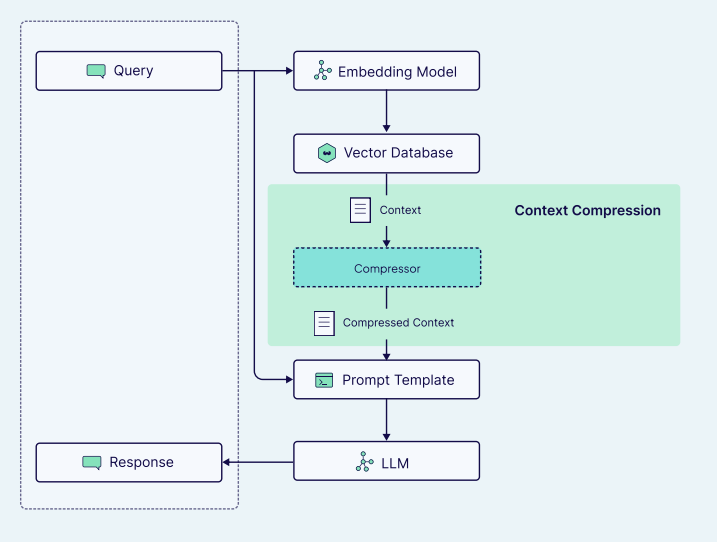

## What is Context Compression?

RAG systems rely on diverse knowledge sources to retrieve relevant information. However, this often results in the retrieval of irrelevant or redundant data, which can lead to suboptimal responses and costly LLM calls (more tokens). Context compression effectively addresses this challenge by extracting only the most meaningful information from the retrieved data.

This process begins with a base retriever that retrieves documents/chunks related to the query. These documents/chunks are then passed through a document compressor that shortens them and eliminates irrelevant content, ensuring that valuable data is not lost in a sea of extraneous information. Contextual compression reduces data volume, lowering retrieval and operational costs. Current research focuses on two main approaches: embedding-based and lexical-based compression, both of which aim to retain essential information while easing computational demands on RAG systems.

Context compression reduces token usage and improves focus by:
- **Removing redundant** information
- **Extracting key points** from long documents
- **Filtering irrelevant** content
- **Summarizing** while preserving important details

### Benefits:
- Lower API costs (fewer tokens)
- Faster processing
- Better focus on relevant information
- Reduced noise in generation

In [ ]:
# LLM-based Document Compressor
from langchain.retrievers.document_compressors import LLMChainExtractor

# Initialize a cost-efficient LLM for compression tasks
# gpt-4o-mini: Smaller, faster model suitable for compression tasks
# temperature=0: Deterministic output for consistent compression
compression_llm = ChatOpenAI(
    model="gpt-4o-mini",  # Cost-efficient model
    temperature=0
)

# Create LLM-based compressor that extracts relevant content
# LLMChainExtractor: Uses an LLM to identify and extract relevant portions
# The LLM analyzes each document and keeps only query-relevant content
llm_compressor = LLMChainExtractor.from_llm(compression_llm)

# Create compression retriever that applies compression after retrieval
# This pipeline: retrieve -> compress -> return compressed results
compression_retriever = ContextualCompressionRetriever(
    base_compressor=llm_compressor,
    base_retriever=base_retriever
)

print("🗜️ LLM-based compressor initialized")

In [ ]:
# Demonstrate the difference between original and compressed retrieval
# This shows how compression can reduce token usage while maintaining relevance
query = "What is the difference between machine learning and deep learning?"

print("🔍 Query:", query)
print("\n" + "="*60 + "\n")

# Get original documents without compression
# This shows the full content that would be sent to the LLM
original_docs = base_retriever.invoke(query)
print("📄 Original Documents:")
for i, doc in enumerate(original_docs):
    print(f"{i+1}. Length: {len(doc.page_content)} chars")
    print(f"   Content: {doc.page_content}")
    print()

print("-"*60 + "\n")

# Get compressed documents that focus only on query-relevant content
# The compressor removes irrelevant information and keeps only what matters
compressed_docs = compression_retriever.invoke(query)
print("🗜️ Compressed Documents:")
for i, doc in enumerate(compressed_docs):
    print(f"{i+1}. Length: {len(doc.page_content)} chars")
    print(f"   Content: {doc.page_content}")
    print()

# 4. Advanced Prompting Strategies

## Advanced Prompting for RAG

The generated outputs of LLMs are greatly influenced by the quality, tone, length, and structure of their corresponding prompts. Prompt engineering is the practice of optimizing LLM prompts to improve the quality and accuracy of generated output. Often one of the lowest-hanging fruits when it comes to techniques for improving RAG systems, prompt engineering does not require making changes to the underlying LLM itself. This makes it an efficient and accessible way to enhance performance without complex modifications.

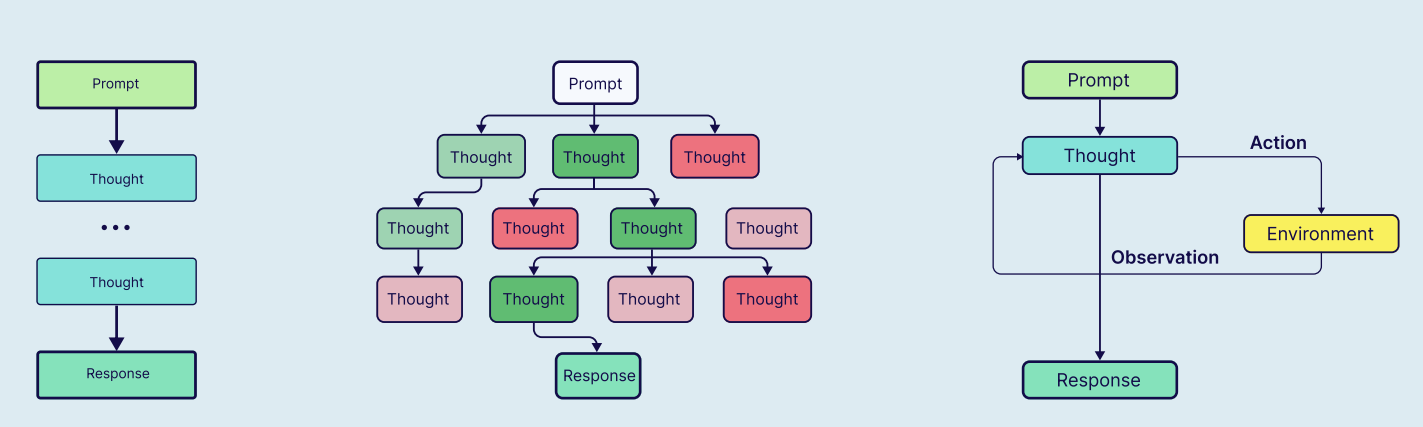

There are several different prompting techniques that are especially useful in improving RAG pipelines:

### Chain of Thought (CoT)
Chain of Thought (CoT) prompting involves asking the model to "think step-by-step" and break down complex reasoning tasks into a series of intermediate steps. This can be especially useful when retrieved documents contain conflicting or dense information that requires careful analysis.
- Step-by-step reasoning
- Better handling of complex queries
- Improved accuracy for multi-step problems

### Tree of Thoughts (ToT)
Tree of Thoughts (ToT) prompting builds on CoT by instructing the model to evaluate its responses at each step in the problem-solving process or even generate several different solutions to a problem and choose the best result. This is useful in RAG when there are many potential pieces of evidence, and the model needs to weigh different possible answers based on multiple retrieved documents.
- Multiple solution paths
- Self-evaluation of responses
- Best result selection

### ReAct (Reasoning + Acting)
ReAct (Reasoning and Acting) prompting combines CoT with agents, creating a system in which the model can generate thoughts and delegate actions to agents that interact with external data sources in an iterative process. ReAct can improve RAG pipelines by enabling LLMs to dynamically interact with retrieved documents, updating reasoning and actions based on external knowledge to provide more accurate and contextually relevant responses.
- Iterative thinking and action
- Dynamic interaction with knowledge
- Adaptive reasoning based on retrieved content

In [ ]:
# Chain of Thought Prompt Template
# This template guides the model through systematic step-by-step reasoning
# Each step helps ensure thorough analysis of the retrieved context
cot_template = ChatPromptTemplate.from_template("""
You are an AI assistant answering questions using retrieved context. 
Follow these steps to provide a comprehensive answer:

Step 1: Analyze the query and identify key concepts
Step 2: Review the provided context for relevant information  
Step 3: Synthesize information from multiple sources if available
Step 4: Provide a clear, well-reasoned answer
Step 5: Acknowledge any limitations or uncertainties

Context:
{context}

Question: {question}

Let me think through this step by step:
""")

print("🧠 Chain of Thought prompt template created")

In [ ]:
# Tree of Thoughts Prompt Template
# This template encourages the model to explore multiple approaches
# It then evaluates and selects the best approach for the answer
tot_template = ChatPromptTemplate.from_template("""
You are an expert AI assistant. Generate multiple approaches to answer this question, 
then evaluate and select the best response.

Context:
{context}

Question: {question}

Approach 1: Direct factual response
[Generate a straightforward factual answer]

Approach 2: Comparative analysis
[Compare different aspects or viewpoints from the context]

Approach 3: Detailed explanation
[Provide in-depth explanation with examples]

Evaluation:
[Evaluate which approach best addresses the question]

Best Answer:
[Provide the most appropriate response based on evaluation]
""")

print("🌳 Tree of Thoughts prompt template created")

In [ ]:
# ReAct Prompt Template
# This template combines reasoning with action-oriented thinking
# It helps the model think about what information it has and what it might need
react_template = ChatPromptTemplate.from_template("""
You are an AI assistant that thinks step by step and can request additional information.

Available Context:
{context}

Question: {question}

Think: [Analyze what information you have and what might be missing]
Act: [Describe what additional context would be helpful, or proceed with available info]
Observe: [Note what information supports or contradicts your reasoning]
Think: [Refine your understanding based on observations]
Answer: [Provide final answer with confidence level]
""")

print("⚡ ReAct prompt template created")

In [ ]:
# Helper function to format retrieved documents for prompt context
# This creates a clean text representation of multiple documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Initialize LLM for generating responses with different prompting strategies
# gpt-4o-mini: Efficient model for demonstration purposes
# temperature=0: Consistent, deterministic responses
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Create RAG chains with different prompting strategies
# Each chain combines retrieval with a specific prompting approach

# Chain of Thought RAG pipeline
# Retrieves documents, formats them, applies CoT template, and generates response
cot_chain = (
    {"context": cohere_retriever | format_docs, "question": RunnablePassthrough()}
    | cot_template
    | llm
    | StrOutputParser()
)

# Tree of Thoughts RAG pipeline
# Explores multiple approaches before settling on the best answer
tot_chain = (
    {"context": cohere_retriever | format_docs, "question": RunnablePassthrough()}
    | tot_template
    | llm
    | StrOutputParser()
)

# ReAct RAG pipeline
# Combines reasoning with action-oriented thinking
react_chain = (
    {"context": cohere_retriever | format_docs, "question": RunnablePassthrough()}
    | react_template
    | llm
    | StrOutputParser()
)

print("🔗 RAG chains with advanced prompting created")

In [ ]:
# Compare different prompting strategies on a complex query
# This demonstrates how different prompting approaches can lead to different response styles
complex_query = "How do transformers differ from traditional neural networks and why are they important for NLP?"

print("🔍 Complex Query:", complex_query)
print("\n" + "="*80 + "\n")

# Chain of Thought Response
# Shows systematic step-by-step reasoning
print("🧠 Chain of Thought Response:")
cot_response = cot_chain.invoke(complex_query)
print(cot_response)

print("\n" + "-"*80 + "\n")

# Tree of Thoughts Response
# Shows multiple approaches and evaluation
print("🌳 Tree of Thoughts Response:")
tot_response = tot_chain.invoke(complex_query)
print(tot_response)

# ReAct (Reasoning and Acting) Response
# Shows iterative thinking and action-oriented approach
print("🌳 ReAct (Reasoning and Acting) Response:")
react_response = react_chain.invoke(complex_query)
print(react_response)

# 5. Hierarchical Indexing

Traditional flat indexing methods can struggle with large documents or corpus, potentially missing context or returning irrelevant information. Hierarchical indexing addresses this by creating a two-tier search system, allowing for more efficient and context-aware retrieval.

### Hierarchical Retrieval
The  function implements the two-tier search:

1. It first searches the summary vector store to identify relevant document sections.
2. For each relevant summary, it then searches the detailed chunk vector store, filtering by the corresponding page number.
4. This approach ensures that detailed information is retrieved only from the most relevant document sections.

### Benefits of this Approach
1. Improved Retrieval Efficiency: By first searching summaries, the system can quickly identify relevant document sections without processing all detailed chunks.
2. Better Context Preservation: The hierarchical approach helps maintain the broader context of retrieved information.
3. Scalability: This method is particularly beneficial for large documents or corpus, where flat searching might be inefficient or miss important context.
4. Flexibility: The system allows for adjusting the number of summaries and chunks retrieved, enabling fine-tuning for different use cases.

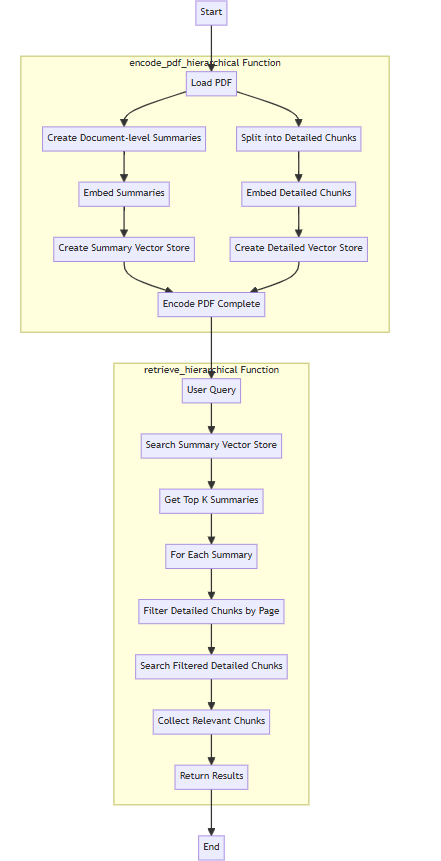
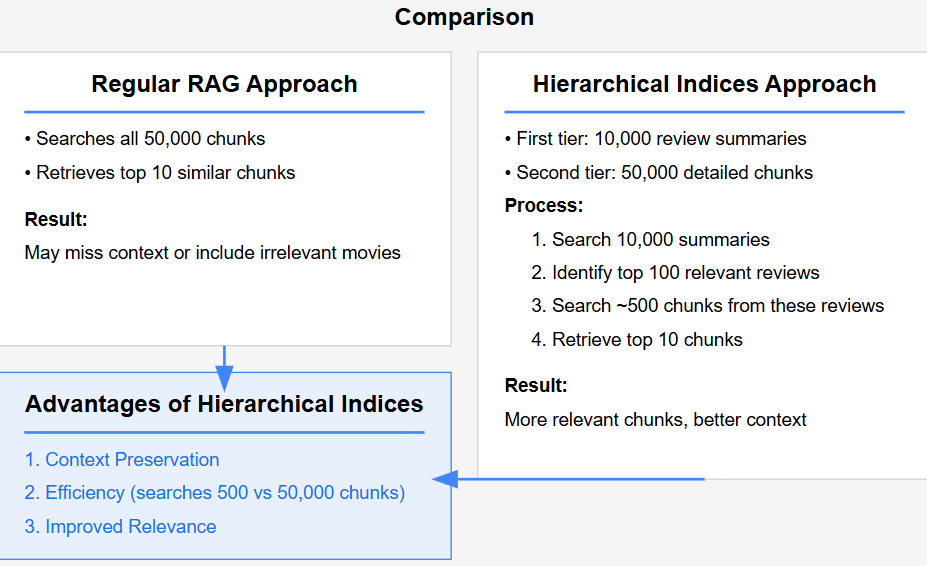

In [ ]:
# Function to create hierarchical document representations
# This implements the encoding phase of hierarchical indexing
def create_hierarchical_docs(docs):
    """Create hierarchical representations with summaries and details.
    
    This function takes original documents and creates two representations:
    1. High-level summaries for broad matching
    2. Detailed content for specific information
    
    Args:
        docs: List of Document objects to process
        
    Returns:
        List of Document objects with both summaries and details
    """
    # Use a smaller LLM model for cost-effective summarization
    summary_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    hierarchical_docs = []
    
    print(f"📄 Creating summaries for {len(docs)} documents...")
    
    for i, doc in enumerate(docs):
        # Create concise summary for high-level retrieval
        # Summary helps with broad topic matching
        summary_prompt = f"Summarize this in 1-2 sentences: {doc.page_content}"
        summary_response = summary_llm.invoke(summary_prompt)

        # Extract string content from LLM response
        if hasattr(summary_response, 'content'):
            summary = str(summary_response.content)
        else:
            summary = str(summary_response)
        
        # Create high-level summary document
        # Tagged with metadata to identify as summary and link to parent
        summary_doc = Document(
            page_content=summary,
            metadata={"type": "summary", "parent_id": i, "level": "high"}
        )
        
        # Create detailed document with full content
        # Tagged with metadata to identify as detail and link to parent
        detail_doc = Document(
            page_content=doc.page_content,
            metadata={"type": "detail", "parent_id": i, "level": "detailed"}
        )
        
        hierarchical_docs.extend([summary_doc, detail_doc])
    
    print(f"✅ Created {len(hierarchical_docs)} hierarchical documents ({len(docs)} summaries + {len(docs)} details)")
    return hierarchical_docs


In [ ]:
# Hierarchical Retrieval System implementation
# This implements the retrieval phase of hierarchical indexing
class HierarchicalRetriever:
    def __init__(self, hierarchical_docs, embeddings):
        """Initialize hierarchical retriever with separate vector stores.
        
        Args:
            hierarchical_docs: Documents with both summaries and details
            embeddings: Embedding model for creating vector representations
        """
        # Separate documents by type for specialized retrieval
        self.summary_docs = [doc for doc in hierarchical_docs if doc.metadata['type'] == 'summary']
        self.detail_docs = [doc for doc in hierarchical_docs if doc.metadata['type'] == 'detail']
        
        print("🗄️ Creating vector stores...")
        # Create separate vector stores for summaries and details
        # Summary store: For broad topic matching
        self.summary_store = Chroma.from_documents(
            self.summary_docs, embeddings, persist_directory="./summary_db"
        )
        # Detail store: For specific information retrieval
        self.detail_store = Chroma.from_documents(
            self.detail_docs, embeddings, persist_directory="./detail_db"
        )
        print("✅ Vector stores ready")
    
    def retrieve(self, query, strategy="hierarchical_flow", top_k_summaries=3, top_k_details=2):
        """Perform hierarchical retrieval following the multi-stage process.
        
        Args:
            query: User question to search for
            strategy: Retrieval strategy to use
            top_k_summaries: Number of summaries to retrieve
            top_k_details: Number of details per summary to retrieve
            
        Returns:
            List of relevant detail documents
        """
        
        if strategy == "hierarchical_flow":
            # Step 1: Search Summary Vector Store for broad topic matching
            print(f"\n🔍 Step 1: Search Summary Vector Store for: '{query}'")
            summary_results = self.summary_store.similarity_search(query, k=top_k_summaries)
            
            # Step 2: Get Top K Summaries with UNIQUE parent_ids
            # Avoid duplicate documents from the same source
            print(f"📊 Step 2: Got {len(summary_results)} summaries")
            
            # Get unique parent_ids to avoid duplicates
            unique_parents = {}
            for summary in summary_results:
                parent_id = summary.metadata['parent_id']
                if parent_id not in unique_parents:
                    unique_parents[parent_id] = summary
            
            print(f"📊 Found {len(unique_parents)} unique parent documents")
            
            all_relevant_chunks = []
            
            # Step 3: For Each Unique Parent, search within its detailed content
            print(f"🔍 Step 3: Processing each unique parent...")
            for i, (parent_id, summary) in enumerate(unique_parents.items()):
                print(f"  Processing Document {parent_id}")
                
                # Step 4: Filter Detailed Chunks by Parent ID
                # Only search within documents that had relevant summaries
                print(f"🔍 Step 4: Filter Detailed Chunks by Parent ID {parent_id}")
                filtered_detail_docs = [
                    doc for doc in self.detail_docs 
                    if doc.metadata['parent_id'] == parent_id
                ]
                
                if filtered_detail_docs:
                    # Step 5: Search Filtered Detailed Chunks for specific information
                    print(f"🔍 Step 5: Search Filtered Detailed Chunks")
                    # Create temporary vector store for this document's details
                    temp_detail_store = Chroma.from_documents(
                        filtered_detail_docs, 
                        self.detail_store._embedding_function,
                        collection_name=f"temp_details_{parent_id}_{i}"
                    )
                    
                    # Search within this document for query-relevant details
                    relevant_chunks = temp_detail_store.similarity_search(query, k=top_k_details)
                    
                    # Step 6: Collect Relevant Chunks
                    all_relevant_chunks.extend(relevant_chunks)
            
            print(f"✅ Step 7: Collected {len(all_relevant_chunks)} relevant chunks")
            # Step 8: Return Results
            return all_relevant_chunks
        
        # Default fallback
        return []


In [ ]:

# Comprehensive demonstration of hierarchical indexing
def main():
    """Main function demonstrating the complete hierarchical indexing workflow."""
    # Expanded sample documents covering different AI domains
    # This provides a richer dataset for hierarchical retrieval demonstration
    sample_docs = [
        # Basic ML Concepts (0-2)
        "Machine learning is a subset of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed. It involves algorithms that can identify patterns in data and make predictions or decisions based on statistical analysis.",
        "Deep learning is a subset of machine learning that uses neural networks with multiple layers to model and understand complex patterns in data. It has revolutionized fields like computer vision and natural language processing by enabling machines to learn hierarchical representations automatically.",
        "Supervised learning is a machine learning approach where algorithms learn from labeled training data to make predictions on new, unseen data. Common supervised learning tasks include classification (predicting categories) and regression (predicting continuous values).",
        
        # Advanced ML Techniques (3-5)
        "Reinforcement learning is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize cumulative reward. It's inspired by behavioral psychology and has applications in robotics, game playing, and autonomous systems.",
        "Unsupervised learning involves finding hidden patterns in data without labeled examples. Key techniques include clustering (grouping similar data points), dimensionality reduction (simplifying data while preserving important features), and anomaly detection.",
        "Feature engineering is the process of selecting, modifying, or creating new features from raw data to improve machine learning model performance. It requires domain expertise and understanding of the underlying data patterns and relationships.",
        
        # NLP and Language Models (6-8)
        "Natural Language Processing (NLP) is a branch of AI that helps computers understand, interpret and manipulate human language. It combines computational linguistics with statistical and machine learning models to process text and speech data.",
        "Transformers are a neural network architecture that has revolutionized NLP through self-attention mechanisms. They process sequential data in parallel rather than sequentially, enabling faster training and better performance on language tasks.",
        "Large Language Models (LLMs) like GPT, BERT, and Claude are AI models trained on vast amounts of text data to understand and generate human-like text. They demonstrate emergent capabilities in reasoning, coding, and creative tasks.",
        
        # Computer Vision (9-11)
        "Computer vision is an AI field that trains machines to interpret and understand visual information from the world. It involves methods for acquiring, processing, analyzing and understanding digital images and videos to extract meaningful information.",
        "Convolutional Neural Networks (CNNs) are specialized deep learning architectures designed for processing grid-like data such as images. They use convolutional layers to detect features like edges, textures, and complex patterns hierarchically.",
        "Object detection combines classification and localization to identify and locate multiple objects within images. Popular algorithms include YOLO (You Only Look Once), R-CNN variants, and modern transformer-based approaches like DETR.",
        
        # Data Science and Engineering (12-14)
        "Data preprocessing is a crucial step in machine learning that involves cleaning, transforming, and preparing raw data for analysis. This includes handling missing values, removing outliers, normalizing features, and encoding categorical variables.",
        "Model evaluation and validation techniques help assess machine learning model performance and generalization ability. Common methods include cross-validation, train-test splits, confusion matrices, ROC curves, and various metrics like precision, recall, and F1-score.",
        "MLOps (Machine Learning Operations) is the practice of deploying, monitoring, and maintaining machine learning models in production environments. It includes version control, automated testing, continuous integration, and model monitoring for performance degradation.",
        
        # AI Ethics and Applications (15-17)
        "AI ethics encompasses the moral principles and values that guide the development and deployment of artificial intelligence systems. Key considerations include fairness, transparency, accountability, privacy protection, and avoiding harmful biases in AI decision-making.",
        "Explainable AI (XAI) focuses on creating machine learning models and techniques that provide clear, interpretable explanations for their decisions and predictions. This is crucial for building trust and ensuring accountability in high-stakes applications.",
        "Transfer learning is a machine learning technique where a model trained on one task is adapted for a related task. This approach leverages pre-trained models to achieve better performance with less data and computational resources, especially useful in domains with limited labeled data."
    ]
    
    # Convert to Document objects with metadata
    documents = [Document(page_content=doc, metadata={"id": i, "topic": "AI"}) for i, doc in enumerate(sample_docs)]
    
    # Initialize embeddings for vector storage
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)
    
    # ENCODING PHASE: Create hierarchical structure
    print("🏗️ ENCODING PHASE - Creating hierarchical structure...")
    hierarchical_docs = create_hierarchical_docs(documents)
    
    # Initialize hierarchical retriever (Creates separate vector stores)
    hier_retriever = HierarchicalRetriever(hierarchical_docs, embeddings)
    print("✅ Encoding Complete!")
    
    # RETRIEVAL PHASE: Test with different types of queries
    test_queries = [
        "What is machine learning?",
        "How do neural networks work in computer vision?",
        "What are the ethical considerations in AI?"
    ]
    
    # Test each query with hierarchical retrieval
    for query in test_queries:
        print(f"\n" + "="*80)
        print(f"🔍 RETRIEVAL PHASE - QUERY: {query}")
        print("="*80)
        
        # Perform hierarchical retrieval following the multi-stage process
        hierarchical_results = hier_retriever.retrieve(
            query, 
            strategy="hierarchical_flow",
            top_k_summaries=2,  # Find 2 most relevant document summaries
            top_k_details=1     # Get 1 detail chunk per relevant document
        )

        # Ensure results is a list for consistent processing
        if hierarchical_results is None:
            hierarchical_results = []
        
        # Display final results with source document information
        print(f"\n📄 Final Results:")
        for i, doc in enumerate(hierarchical_results):
            parent_id = doc.metadata.get('parent_id')
            print(f"{i+1}. [Document {parent_id}] {doc.page_content[:100]}...")

# Execute the hierarchical indexing demonstration
if __name__ == "__main__":
    main()

# Best Practices Summary

## When to Use Each Technique:

### Re-ranking
Use re-ranking when you need higher precision in retrieval results. Re-ranking is particularly effective when:
- Your initial retrieval returns many potentially relevant documents
- You need to understand subtle contextual relationships between queries and documents
- You want to improve the relevance of top results without changing your entire retrieval system

**Cohere Re-ranking**: Best for complex queries and multilingual content. Cohere's models are trained on diverse datasets and excel at understanding nuanced relationships.

**FlashRank**: Ideal for fast, cost-effective cross-encoding. Good choice when you need efficient local processing without API calls.

### Context Enhancement
Use context enhancement when your retrieved documents need additional information to be useful for generation:
- When working with small chunks that lack sufficient context
- When metadata can provide valuable additional information
- When implementing sentence window retrieval for precision-recall balance

**Trade-off**: Enhanced context means more tokens, which increases API costs. Balance context richness with cost considerations.

### Context Compression
Context compression is valuable when dealing with long documents that contain redundant content:
- Large documents with repetitive information
- When you need to reduce token usage for cost optimization
- When retrieved content contains noise that might confuse the generation model

**Benefits**: Lower costs, faster processing, and better focus on relevant information
**Risk**: Potential loss of important information during compression

### Advanced Prompting
Different prompting strategies serve different needs:

**Chain of Thought (CoT)**: Use for complex reasoning tasks that benefit from step-by-step analysis

**Tree of Thoughts (ToT)**: Use when multiple solution paths are possible and you want the model to evaluate different approaches

**ReAct**: Use when iterative reasoning is required and the model needs to think about what information it has and what it might need

### Hierarchical Indexing
Hierarchical indexing is most beneficial for:
- Large, complex document collections
- Multi-granularity retrieval needs (both broad topics and specific details)
- When you need to handle long documents efficiently

**Complexity**: Requires more setup and maintenance than simpler approaches, but provides sophisticated retrieval capabilities.

## Implementation Strategy

### Start Simple:
1. **Begin with re-ranking** - Often provides the biggest impact with minimal complexity
2. **Add compression** for cost optimization if dealing with long documents
3. **Experiment with advanced prompting** to improve reasoning quality
4. **Consider hierarchical indexing** for complex use cases with large document sets

### Monitor Key Metrics:
- **Relevance**: Are retrieved results more accurate and useful?
- **Cost**: Track token usage and API costs across different techniques
- **Latency**: Measure response time impact of each optimization
- **Quality**: Monitor user satisfaction and response quality

# Conclusion & Next Steps

## Key Takeaways

This tutorial has covered the essential post-retrieval optimization techniques for RAG systems:

1. **Re-ranking** significantly improves retrieval relevance by processing query-document pairs together
2. **Context enhancement** helps with understanding but increases token costs
3. **Context compression** reduces costs while maintaining information quality
4. **Advanced prompting** enhances reasoning capabilities and response accuracy
5. **Hierarchical indexing** provides sophisticated multi-level retrieval for complex document sets

## Optimization Strategy

When implementing these techniques in your own RAG systems:

### Incremental Implementation:
Start with the techniques that provide the highest impact with the least complexity. Re-ranking often provides immediate improvements and should be your first consideration.

### Cost-Benefit Analysis:
Each technique involves trade-offs between performance improvements and computational costs. Monitor both quality metrics and operational costs to find the right balance for your use case.

### Domain-Specific Considerations:
Different domains may benefit more from certain techniques. Technical domains might benefit more from hierarchical indexing, while customer service applications might see more value from context enhancement.

## Further Exploration

Beyond the techniques covered in this tutorial, consider exploring:

- **Hybrid retrieval**: Combining keyword search with semantic search for even better recall
- **Query expansion**: Enhancing user queries before retrieval
- **Multi-modal RAG**: Incorporating images, tables, and code alongside text
- **Evaluation frameworks**: Tools like RAGAS and TruLens for systematic RAG evaluation
- **Production optimization**: Implementing caching, batching, and other performance optimizations

## Resources for Continued Learning

- **LangChain Documentation**: Comprehensive guides and API references
- **Cohere Rerank Guide**: Best practices for using Cohere's re-ranking models
- **ChromaDB Documentation**: Advanced vector database features and optimization
- **OpenAI Embeddings Guide**: Understanding and optimizing embedding models

The field of RAG optimization is rapidly evolving, with new techniques and improvements being developed regularly. The foundation you've built with these post-retrieval optimization techniques will serve as a solid base for implementing more advanced RAG systems.

Remember that the best RAG system is one that balances accuracy, cost, latency, and maintainability for your specific use case. Start simple, measure results, and iteratively improve based on your users' needs and feedback.